In [147]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

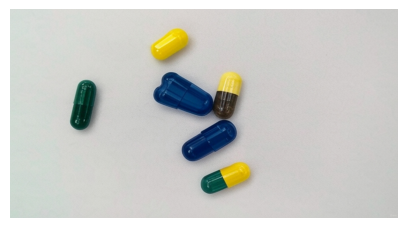

In [148]:
img = cv2.imread("multiple_pill_test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis(False)
plt.show()

# Thresholding


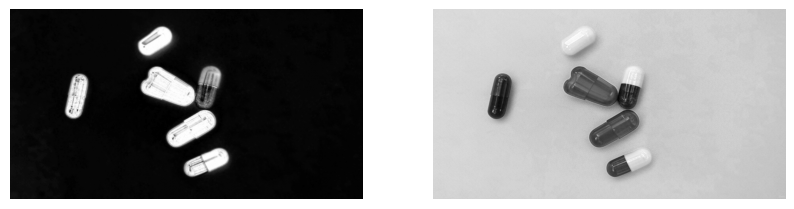

In [164]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
s = hsv[:,:,1]
v = hsv[:,:,2]

fig,axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(s, cmap="gray")
axs[1].imshow(v, cmap="gray")
axs[0].axis(False)
axs[1].axis(False)
plt.show()


In [165]:
s_blur = cv2.GaussianBlur(s, (5,5), 0)
_, thresh = cv2.threshold(s_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

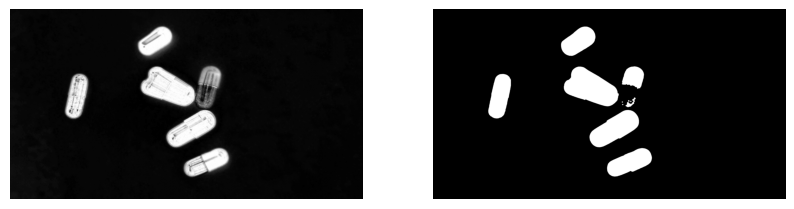

In [166]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(s_blur, cmap="gray")
axs[1].imshow(thresh, cmap="gray")
axs[0].axis(False)
axs[1].axis(False)
plt.show()

In [169]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(thresh.shape, dtype=np.uint8)

print(len(contours))

11


In [170]:
min_area = 400

valid_contours =[]
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > min_area:
        perimeter = cv2.arcLength(cnt, True)
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter ** 2)
            if circularity > 0.3:
                valid_contours.append(cnt)
                cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
print(len(valid_contours))

6


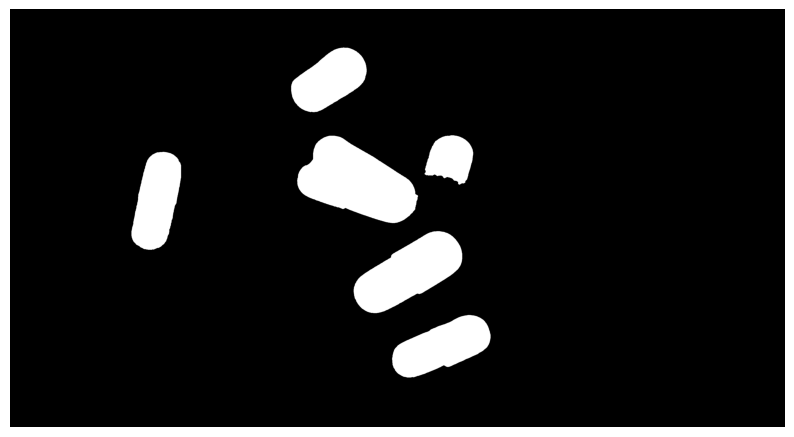

In [174]:
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_small, iterations=1)
mask = (mask > 0).astype(np.uint8) * 255

plt.figure(figsize=(10,10))
plt.imshow(mask, cmap="gray")
plt.axis(False)
plt.show()

In [175]:
# os.makedirs("individual_pills_transparent", exist_ok=True)
# os.makedirs("individual_pills_white_bg", exist_ok=True)

for i, cnt in enumerate(valid_contours):
    single_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(single_mask, [cnt], -1, 255, thickness=cv2.FILLED)

    pill_rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    pill_rgba[:, :, 3] = single_mask

    x, y, w, h = cv2.boundingRect(cnt)
    cropped_pill = pill_rgba[y:y+h, x:x+w]

    transparent_path = f"individual_pills_transparent/pill_{i+1}.png"
    cv2.imwrite(transparent_path, cropped_pill)

    extracted_pills.append(cropped_pill)
    print(f"Pill {i+1} → saved (size: {w}x{h}, area: {int(cv2.contourArea(cnt))} px)")

Pill 1 → saved (size: 476x302, area: 86492 px)
Pill 2 → saved (size: 525x396, area: 115844 px)
Pill 3 → saved (size: 240x473, area: 79778 px)
Pill 4 → saved (size: 584x422, area: 149964 px)
Pill 5 → saved (size: 235x239, area: 39459 px)
Pill 6 → saved (size: 365x313, area: 72386 px)


/tmp/ipython-input-637000838.py:27: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


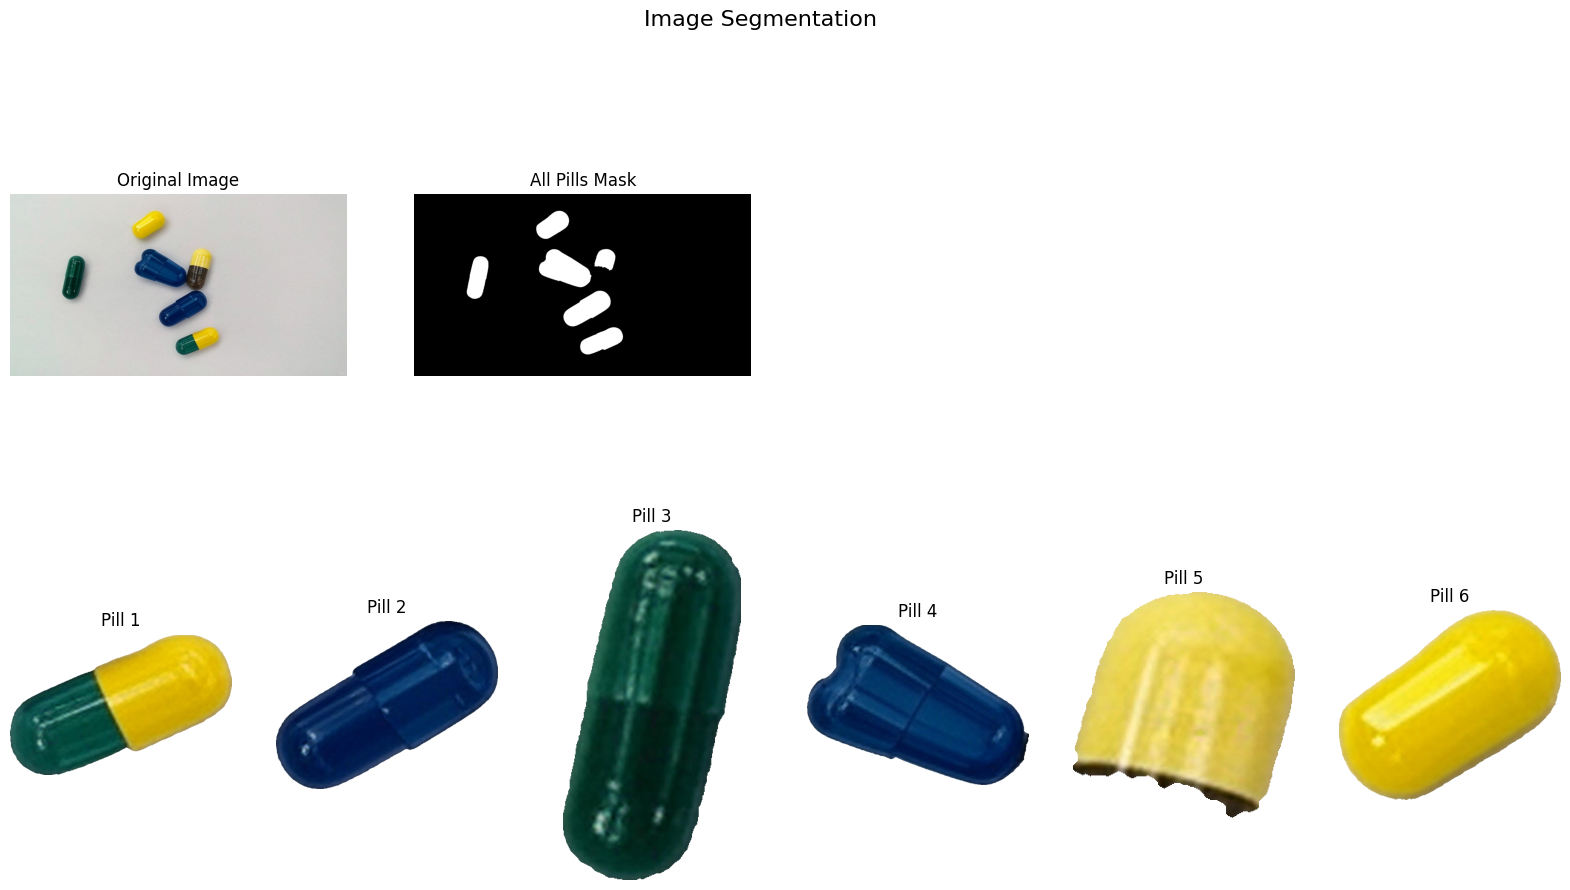

In [176]:
# --------------------- 3. Visualize results ---------------------
plt.figure(figsize=(20, 10))

# Show original
plt.subplot(2, 4, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

# Show full mask
full_mask = np.zeros(img.shape[:2], dtype=np.uint8)
for cnt in valid_contours:
    cv2.drawContours(full_mask, [cnt], -1, 255, -1)
plt.subplot(2, 4, 2)
plt.title("All Pills Mask")
plt.imshow(full_mask, cmap='gray')
plt.axis('off')

# Show first 6 extracted pills (transparent background)
for i in range(min(6, len(extracted_pills))):
    plt.subplot(2, 6, 7 + i)
    plt.title(f"Pill {i+1}")
    plt.imshow(extracted_pills[i])
    plt.axis('off')

plt.suptitle("Image Segmentation", fontsize=16)
plt.tight_layout()
plt.show()